In [1]:
from src import attributes as a
%load_ext autoreload
%autoreload 2

In [2]:
# Global Variables
stock_name = 'iyw' # ticker symbol
model_name = 'Random Forest Classifier' # for display later
days_ahead = 1 # for predicting 1 day ahead
cv = 5 # number of cross validation folds

In [3]:
# Extract, Transform, Load, and Train Test Split
# aapl start date: 12/12/1980
# tsla start date: 06/29/2010
# vbiv start date: 09/04/2002
# vgt start date: 01/26/2004
# idex start date: 05/23/2007
# iyw start date: 05/15/2000
# 
X_train, X_test, y_train, y_test, stock_df = a.data(stock_name, '05/15/2000', days_ahead)

In [4]:
stock_df.tail(10)

,High,Low,Open,Close,Volume,Adj Close,oc,hl,adj,5stdev_adj,5sma_adj,direction
Date,,,,,,,,,,,,
2020-12-10,82.470001,81.000000,81.220001,82.129997,255000.0,82.051979,-0.011204,0.018148,0.005140,0.012228,-0.000183,-1
2020-12-11,82.139999,81.169998,81.680000,82.110001,171500.0,82.032005,-0.005264,0.011950,-0.000243,0.011295,-0.001904,1
2020-12-14,82.879997,82.199997,82.309998,82.260002,225400.0,82.260002,0.000607,0.008273,0.002779,0.011194,-0.002077,1
2020-12-15,83.589996,82.690002,83.010002,83.589996,193800.0,83.589996,-0.006987,0.010884,0.016168,0.013870,0.000411,-1
2020-12-16,84.389999,83.400002,83.669998,84.139999,202500.0,84.139999,-0.005617,0.011870,0.006580,0.006200,0.006085,-1
2020-12-17,84.870003,84.290001,84.709999,84.660004,471800.0,84.660004,0.000590,0.006881,0.006180,0.006178,0.006293,-1
2020-12-18,84.849998,83.970001,84.849998,84.480003,403300.0,84.480003,0.004361,0.010480,-0.002126,0.006711,0.005916,1
2020-12-21,84.709999,82.839996,83.540001,84.669998,329200.0,84.669998,-0.013526,0.022574,0.002249,0.006777,0.005810,1
2020-12-22,85.839996,84.660004,85.150002,85.449997,357600.0,85.449997,-0.003523,0.013938,0.009212,0.004424,0.004419,-1


In [5]:
# GridSerach to find best hyperparameters to prevent overfitting, can be commented out once trained
a.rfc_GridSearch(X_train, y_train, stock_name, days_ahead, cv)

In [6]:
# Load RandomForextClassifier Model
rfc_model, y_pred, y_probs = a.rfc(X_train, X_test, y_train, stock_name, days_ahead)

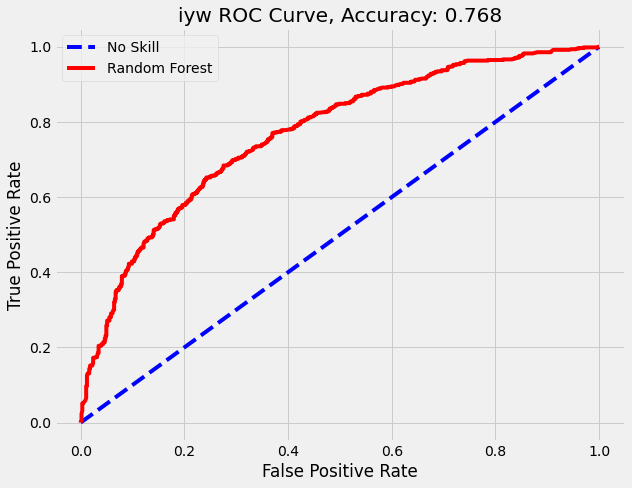

In [7]:
# ROC Curve
a.roc_plot(y_test, y_probs, stock_name, 'Random Forest')

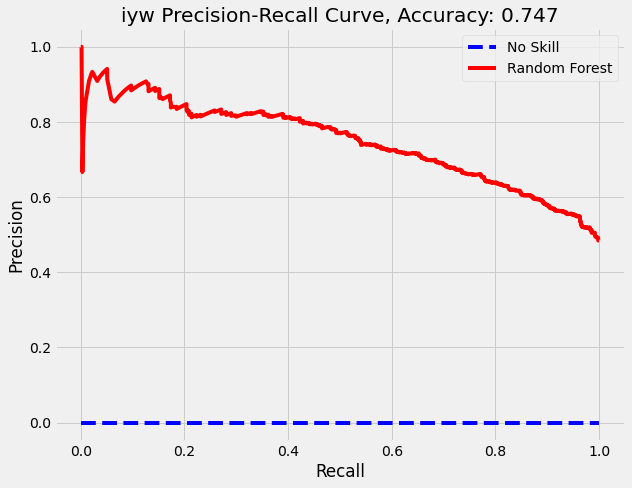

In [8]:
# Precision Recall Curve
a.prec_recall(y_test, y_probs, stock_name, 'Random Forest')

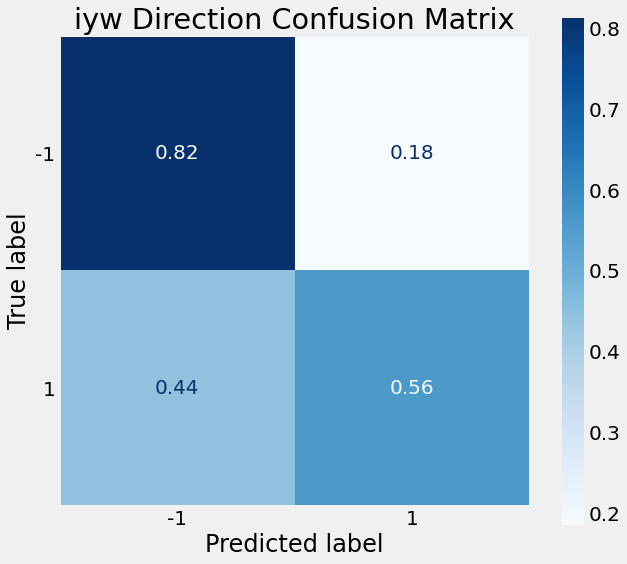

In [9]:
# Confusion Matrix
a.confusion_matrix(rfc_model, X_test, y_test, stock_name)

In [10]:
# Cross Validation
a.cross_validation(rfc_model
                   , stock_df[['oc', 'hl', '5stdev_adj', '5sma_adj']]
                   , stock_df['direction']
                   , cv = 5
                  )

'5 Fold Cross-Validation Score for First RF Model: 0.7091492734970997'

In [11]:
# Prediction
stock_df.iloc[-1]

High             85.739998
Low              85.275002
Open             85.540001
Close            85.220001
Volume        92820.000000
Adj Close        85.220001
oc                0.003741
hl                0.005453
adj              -0.002692
5stdev_adj        0.005172
5sma_adj          0.002565
direction        -1.000000
Name: 2020-12-23 00:00:00, dtype: float64

In [12]:
import numpy as np
last = stock_df[['oc', 'hl', '5stdev_adj', '5sma_adj']].iloc[-1]
last

oc            0.003741
hl            0.005453
5stdev_adj    0.005172
5sma_adj      0.002565
Name: 2020-12-23 00:00:00, dtype: float64

In [13]:
if rfc_model.predict(np.array(last).reshape(1, -1))[0] == 1:
    print(f'Buy {stock_name}')
else:
    print(f'Sell or hold {stock_name}')

Buy iyw


In [14]:
# returns on strategy column
stock_df['prediction'] = rfc_model.predict(stock_df[['oc', 'hl', '5stdev_adj', '5sma_adj']])
stock_df['returns'] = stock_df['adj'].shift(-1, fill_value = stock_df['adj'].median()) * stock_df['prediction']

In [15]:
stock_df.tail(5)

,High,Low,Open,Close,Volume,Adj Close,oc,hl,adj,5stdev_adj,5sma_adj,direction,prediction,returns
Date,,,,,,,,,,,,,,
2020-12-17,84.870003,84.290001,84.709999,84.660004,471800.0,84.660004,0.000590,0.006881,0.006180,0.006178,0.006293,-1,-1,0.002126
2020-12-18,84.849998,83.970001,84.849998,84.480003,403300.0,84.480003,0.004361,0.010480,-0.002126,0.006711,0.005916,1,1,0.002249
2020-12-21,84.709999,82.839996,83.540001,84.669998,329200.0,84.669998,-0.013526,0.022574,0.002249,0.006777,0.005810,1,-1,-0.009212
2020-12-22,85.839996,84.660004,85.150002,85.449997,357600.0,85.449997,-0.003523,0.013938,0.009212,0.004424,0.004419,-1,-1,0.002692
2020-12-23,85.739998,85.275002,85.540001,85.220001,92820.0,85.220001,0.003741,0.005453,-0.002692,0.005172,0.002565,-1,1,0.001104


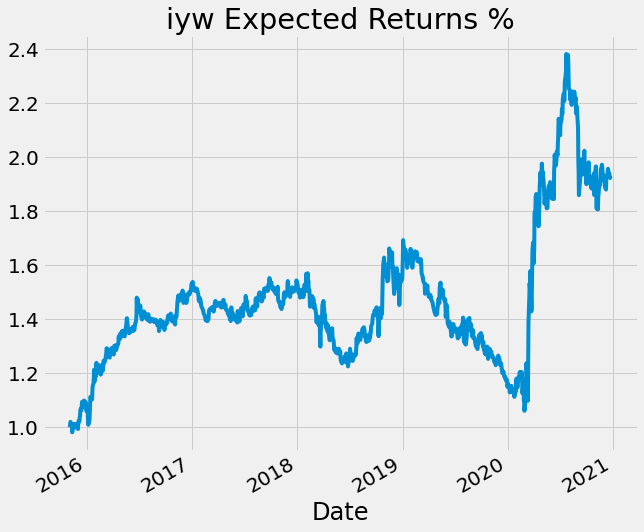

In [16]:
# Don't trade every day!
import matplotlib.pyplot as plt
test_length = len(y_test)
(stock_df['returns'][-test_length:] + 1).cumprod().plot()
plt.title(f'{stock_name} Expected Returns %');

In [17]:
# Model returns if bought on predictions of 1
returns_on_ones = []
for idx in range(-test_length, 0):
    if stock_df['prediction'][idx] == 1:
        returns_on_ones.append(1 + stock_df['returns'][idx])

returns = 1
for x in returns_on_ones:
    returns *= x
returns

2.6943374531641537

In [18]:
# multiple times original investment, not bad but...

In [19]:
# If purchased in 2012 and left it until now
(stock_df['Close'][-1] - stock_df['Close'][-2522]) /stock_df['Close'][-2522]

4.299751344840924

In [20]:
# Buy and hold strategy beats RandomForestClassifier in this study

# Special thanks to Shagufta Tahsildar at https://blog.quantinsti.com/random-forest-algorithm-in-python/